<p style="text-align: center"><img src="https://gitlab.aicrowd.com/aicrowd/assets/-/raw/master/challenges/clock-decomposition/notebook-banner.jpg?inline=false" alt="Drawing" style="height: 400px;"/></p>

# What is the notebook about?

The challenge is to use the features extracted from the Clock Drawing Test to build an automated and algorithm to predict whether each participant is one of three phases:

1)    Pre-Alzheimer’s (Early Warning)
2)    Post-Alzheimer’s (Detection)
3)    Normal (Not an Alzheimer’s patient)

In machine learning terms: this is a 3-class classification task.

# How to use this notebook? 📝

<p style="text-align: center"><img src="https://gitlab.aicrowd.com/aicrowd/assets/-/raw/master/notebook/aicrowd_notebook_submission_flow.png?inline=false" alt="notebook overview" style="width: 650px;"/></p>

- **Update the config parameters**. You can define the common variables here

Variable | Description
--- | ---
`AICROWD_DATASET_PATH` | Path to the file containing test data (The data will be available at `/ds_shared_drive/` on aridhia workspace). This should be an absolute path.
`AICROWD_PREDICTIONS_PATH` | Path to write the output to.
`AICROWD_ASSETS_DIR` | In case your notebook needs additional files (like model weights, etc.,), you can add them to a directory and specify the path to the directory here (please specify relative path). The contents of this directory will be sent to AIcrowd for evaluation.
`AICROWD_API_KEY` | In order to submit your code to AIcrowd, you need to provide your account's API key. This key is available at https://www.aicrowd.com/participants/me

- **Installing packages**. Please use the [Install packages 🗃](#install-packages-) section to install the packages
- **Training your models**. All the code within the [Training phase ⚙️](#training-phase-) section will be skipped during evaluation. **Please make sure to save your model weights in the assets directory and load them in the predictions phase section** 

# Setup AIcrowd Utilities 🛠

We use this to bundle the files for submission and create a submission on AIcrowd. Do not edit this block.

In [ ]:
!pip install -q -U aicrowd-cli

In [1]:
%load_ext aicrowd.magic

# AIcrowd Runtime Configuration 🧷

Define configuration parameters. Please include any files needed for the notebook to run under `ASSETS_DIR`. We will copy the contents of this directory to your final submission file 🙂

The dataset is available under `/ds_shared_drive` on the workspace.

In [2]:
import os

# Please use the absolute for the location of the dataset.
# Or you can use relative path with `os.getcwd() + "test_data/validation.csv"`
AICROWD_TRAIN_DATASET_PATH = os.getenv("TRAIN_DATASET_PATH", "/ds_shared_drive/train.csv")
AICROWD_VAL_DATASET_PATH =os.getenv("VAL_DATASET_PATH", "/ds_shared_drive/validation_ground_truth.csv")
AICROWD_DATASET_PATH = os.getenv("DATASET_PATH", "/ds_shared_drive/validation.csv")
AICROWD_PREDICTIONS_PATH = os.getenv("PREDICTIONS_PATH", "predictions.csv")
AICROWD_ASSETS_DIR = "assets"


# Install packages 🗃

Please add all pacakage installations in this section

In [3]:
!pip install numpy pandas

In [4]:
! pip install missingno

In [5]:
! pip install  scikit-learn

In [6]:
# catboost, light gbm, XGBoost install
! pip install  catboost
! pip install xgboost
! pip install lightgbm

In [7]:
! pip install imbalanced-learn

In [8]:
! pip install category-encoders

# Define preprocessing code 💻

The code that is common between the training and the prediction sections should be defined here. During evaluation, we completely skip the training section. Please make sure to add any common logic between the training and prediction sections here.

### Import common packages

Please import packages that are common for training and prediction phases here.

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno
%matplotlib inline

In [10]:
import pickle
from sklearn.model_selection  import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score, log_loss
from xgboost import XGBClassifier
from imblearn.over_sampling import RandomOverSampler, SMOTE
from  category_encoders import CountEncoder

###### `note`
- On executing EDA on the provided dataset, I deduced that the features, hor_count, horizonta_dist, pred_tremor, ellipse_circle_ratio and more are crucial in identifying the diagnosis. Although the training data in hand is very inbalanced, I have tried engineering the following handcrafted features based on grouping and transform statistics.

In [11]:
# feat_engg def
def feat_engg(df):
#     df['deviation_dist_from_mid_axis_hor_dist'] = df.groupby('deviation_dist_from_mid_axis')['horizontal_dist'].transform('mean')
    df['deviation_dist_from_mid_axis_hor_count'] = df.groupby('deviation_dist_from_mid_axis')['hor_count'].transform('count')
    df['deviation_dist_from_mid_axis_pred_tremor'] = df.groupby('deviation_dist_from_mid_axis')['pred_tremor'].transform('count')
#     df['final_rotation_angle_hor_dist'] = df.groupby('final_rotation_angle')['horizontal_dist'].transform('mean')
    df['number_of_digits_perc_inside'] = df.groupby('number_of_digits')['percentage_inside_ellipse'].transform('mean')
    df['between_axis_digits_angle_var_perc_inside'] = df.groupby('between_axis_digits_angle_var')['percentage_inside_ellipse'].transform('mean')
    df['double_minor_ellipse_circle_ratio'] = df.groupby('double_minor')['ellipse_circle_ratio'].transform('mean')
    df['double_minor_count_defects'] = df.groupby('double_minor')['count_defects'].transform('mean')
#     df['double_minor_pred_tremor'] = df.groupby('double_minor')['pred_tremor'].transform('count')
    df['ellipse_circle_ratio_double_minor'] = df.groupby('ellipse_circle_ratio')['double_minor'].transform('mean')
    df['ellipse_circle_ratio_count_defects'] = df.groupby('ellipse_circle_ratio')['count_defects'].transform('mean')
#     df['horizontal_dist_intersect_pos_rel_centre'] = df.groupby('horizontal_dist')['intersection_pos_rel_centre'].transform('count')
#     df['other_error_sequence_flag_cw'] = df.groupby('other_error')['sequence_flag_cw'].transform('count')

# Training phase ⚙️

You can define your training code here. This sections will be skipped during evaluation.

## Load training data

In [12]:
train_data = pd.read_csv(AICROWD_TRAIN_DATASET_PATH)
valid_data = pd.read_csv(AICROWD_DATASET_PATH)

In [13]:
train_data.head(2)

,row_id,number_of_digits,missing_digit_1,missing_digit_2,missing_digit_3,missing_digit_4,missing_digit_5,missing_digit_6,missing_digit_7,missing_digit_8,...,bottom_area_perc,left_area_perc,right_area_perc,hor_count,vert_count,eleven_ten_error,other_error,time_diff,centre_dot_detect,diagnosis
0,S0CIXBKIUEOUBNURP,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.52617,0.524975,0.474667,0,0,0,1,-105.0,0.0,normal
1,IW1Z4Z3H720OPW8LL,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00081,0.516212,0.483330,0,1,0,1,NaN,NaN,normal


In [14]:
valid_data.head(2)

,row_id,number_of_digits,missing_digit_1,missing_digit_2,missing_digit_3,missing_digit_4,missing_digit_5,missing_digit_6,missing_digit_7,missing_digit_8,...,top_area_perc,bottom_area_perc,left_area_perc,right_area_perc,hor_count,vert_count,eleven_ten_error,other_error,time_diff,centre_dot_detect
0,LA9JQ1JZMJ9D2MBZV,11.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.500272,0.499368,0.553194,0.446447,0,0,0,1,NaN,NaN
1,PSSRCWAPTAG72A1NT,6.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.572472,0.427196,0.496352,0.503273,0,1,0,1,NaN,NaN


In [15]:
ID_COL, TARGET_COL = 'row_id', 'diagnosis'

In [16]:
def join_df(train, valid):
  df = pd.concat([train.iloc[:, :-1], valid], axis=0).reset_index(drop = True)
  features = [c for c in df.columns if c not in [ID_COL, TARGET_COL]]
  return df, features

# def split_df_and_get_features(df, train_nrows):
#   train, valid = df[:train_nrows].reset_index(drop = True), df[train_nrows:].reset_index(drop = True)
#   features = [c for c in train.columns if c not in [ID_COL, TARGET_COL]]
#   return train, test, features

In [17]:
df, features_after_join = join_df(train_data, valid_data)
df.head()

,row_id,number_of_digits,missing_digit_1,missing_digit_2,missing_digit_3,missing_digit_4,missing_digit_5,missing_digit_6,missing_digit_7,missing_digit_8,...,top_area_perc,bottom_area_perc,left_area_perc,right_area_perc,hor_count,vert_count,eleven_ten_error,other_error,time_diff,centre_dot_detect
0,S0CIXBKIUEOUBNURP,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.473488,0.526170,0.524975,0.474667,0,0,0,1,-105.0,0.0
1,IW1Z4Z3H720OPW8LL,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.999180,0.000810,0.516212,0.483330,0,1,0,1,NaN,NaN
2,PVUGU14JRSU44ZADT,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.511519,0.488109,0.550606,0.449042,0,0,0,0,0.0,0.0
3,RW5UTGMB9H67LWJHX,7.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,...,NaN,NaN,NaN,NaN,1,0,0,1,NaN,NaN
4,W0IM2V6F6UP5LYS3E,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.486856,0.512818,0.511865,0.487791,0,1,0,0,0.0,1.0


In [18]:
regr_features = []
cat_features = []

#### Extending regr_features and cat_features from saved lists/arrays

In [19]:
# these features were stored in seperate arrays and computed in other notebooks, which I haven't  included here for brevity
clock_features = np.load(AICROWD_ASSETS_DIR+'/clockfeat.npz')['clkfeat'].tolist()
hand_features = np.load(AICROWD_ASSETS_DIR+'/handfeat.npz')['hfeat'].tolist()
circle_features = np.load(AICROWD_ASSETS_DIR+'/circlefeat.npz')['cirfeat'].tolist()

In [20]:
regr_features.extend(np.load(AICROWD_ASSETS_DIR+'/clockfeat.npz')['clkregrfeat'].tolist())
cat_features.extend(np.load(AICROWD_ASSETS_DIR+'/clockfeat.npz')['clkcatfeat'].tolist())
regr_features.extend(np.load(AICROWD_ASSETS_DIR+'/handfeat.npz')['hregrfeat'].tolist())
cat_features.extend(np.load(AICROWD_ASSETS_DIR+'/handfeat.npz')['hcatfeat'].tolist())
regr_features.extend(np.load(AICROWD_ASSETS_DIR+'/circlefeat.npz')['ciregrfeat'].tolist())
cat_features.extend(np.load(AICROWD_ASSETS_DIR+'/circlefeat.npz')['circatfeat'].tolist())

In [21]:
bold = '\033[1m'
ordinary = '\033[0m'

In [22]:
# final list of regr_features and cat_features
print(f'{bold}Regression features: {ordinary}{regr_features}', '\n', '\n', f'{bold}Categorical features: {ordinary}{cat_features}')

Regression features: ['final_rotation_angle', 'number_of_digits', 'deviation_dist_from_mid_axis', 'between_axis_digits_angle_sum', 'between_axis_digits_angle_var', 'between_digits_angle_cw_sum', 'between_digits_angle_cw_var', 'between_digits_angle_ccw_sum', 'between_digits_angle_ccw_var', 'number_of_hands', 'hour_hand_length', 'minute_hand_length', 'single_hand_length', 'clockhand_ratio', 'clockhand_diff', 'angle_between_hands', 'deviation_from_centre', 'hour_proximity_from_11', 'minute_proximity_from_2', 'ellipse_circle_ratio', 'count_defects', 'percentage_inside_ellipse', 'double_major', 'double_minor', 'top_area_perc', 'bottom_area_perc', 'left_area_perc', 'right_area_perc', 'horizontal_dist', 'vertical_dist', 'euc_dist_digit_1', 'euc_dist_digit_2', 'euc_dist_digit_3', 'euc_dist_digit_4', 'euc_dist_digit_5', 'euc_dist_digit_6', 'euc_dist_digit_7', 'euc_dist_digit_8', 'euc_dist_digit_9', 'euc_dist_digit_10', 'euc_dist_digit_11', 'euc_dist_digit_12', '1 dist from cen', '2 dist from ce

#### Overview of all data

##### Functions

In [25]:
def show_missing_data(data):
    df_miss = 100 * data.isnull().sum().sort_values(ascending=False) / data.shape[0]
    for i in [1, 5, 10, 15, 20, 30, 50]:
        print(f'More than {len(df_miss[df_miss > i])} columns with a percentage of omissions greater than {i}%')
    plt.figure(figsize=(10, 10))
    sns.barplot(x=df_miss.head(20).values, y=df_miss.head(20).index)
    plt.title('Top 20 columns by number of omissions')
    
def show_corr_all(data):
    df_corr = data.copy()
    df_corr['diagnosis'] = pd.factorize(df_corr['diagnosis'])[0]
    df_corr['intersection_pos_rel_centre'] = pd.factorize(df_corr['intersection_pos_rel_centre'])[0]
    df_corr = df_corr.corr()['diagnosis'].sort_values(ascending=False).iloc[1:-2]
    df_corr = pd.concat([df_corr.head(20), df_corr.tail(10)])
    plt.figure(figsize=(10, 10))
    sns.barplot(x=df_corr.values, y=df_corr.index)
    plt.title('Top 20 correlation from the beggining and top 10 from the end')
    
def dist_diagnosis(data):
    plt.figure(figsize=(10, 5))
    sns.barplot(x=sorted(data.diagnosis.unique()), y=data.groupby('diagnosis').row_id.count(), palette='rocket')
    plt.ylabel('Count')
    plt.show()

##### Missing Values

More than 91 columns with a percentage of omissions greater than 1%
More than 80 columns with a percentage of omissions greater than 5%
More than 77 columns with a percentage of omissions greater than 10%
More than 51 columns with a percentage of omissions greater than 15%
More than 26 columns with a percentage of omissions greater than 20%
More than 16 columns with a percentage of omissions greater than 30%
More than 2 columns with a percentage of omissions greater than 50%


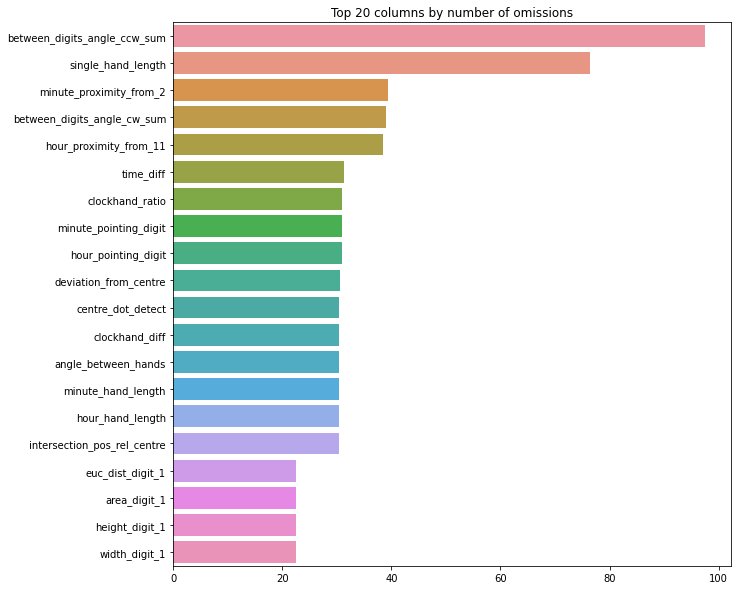

In [26]:
# show_missing_data(train_data)
show_missing_data(df)

In [27]:
# These features are either most missing or redundant
discard_feat = ['between_digits_angle_ccw_sum', 'hand_count_dummy', 'single_hand_length']

##### Top correlations

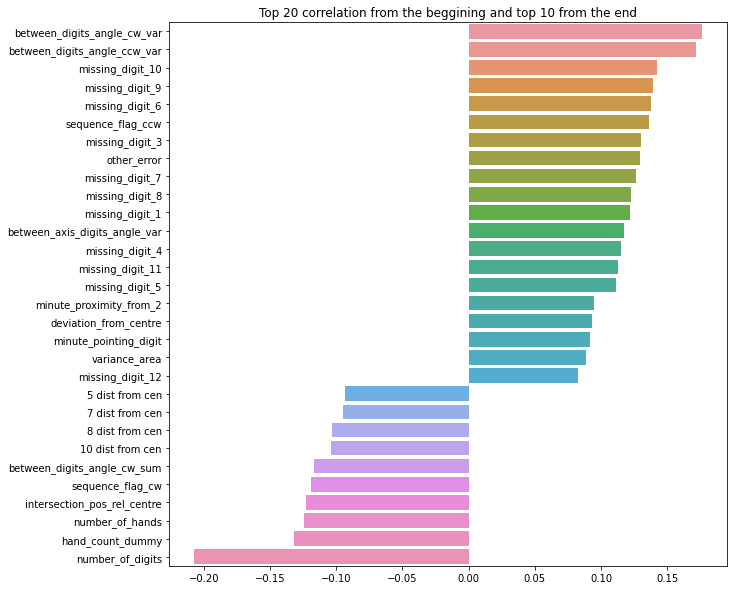

In [30]:
show_corr_all(train_data)

##### Diagnosis Distribution

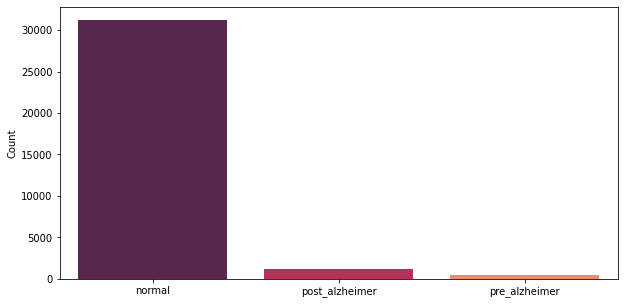

In [31]:
dist_diagnosis(train_data)

#### Missing values visualization -- using `missingno`

<AxesSubplot:>

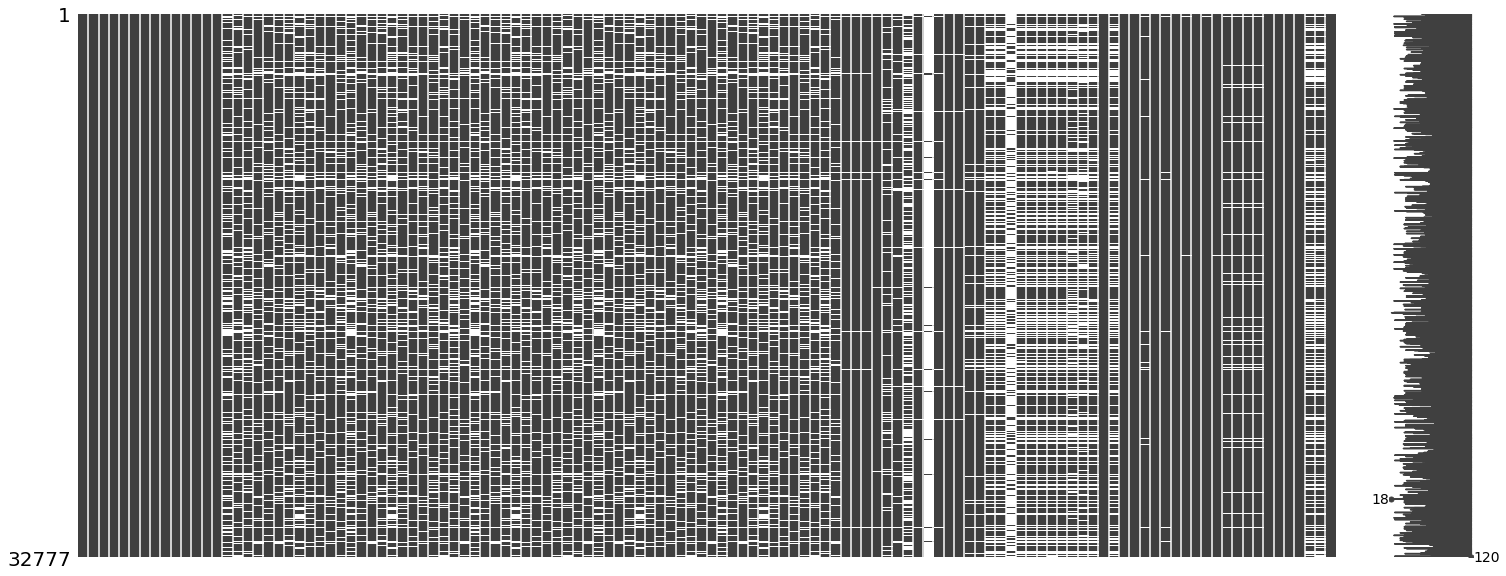

In [33]:
missingno.matrix(train_data)

##### Finding possible correlation between the  missing values

<AxesSubplot:>

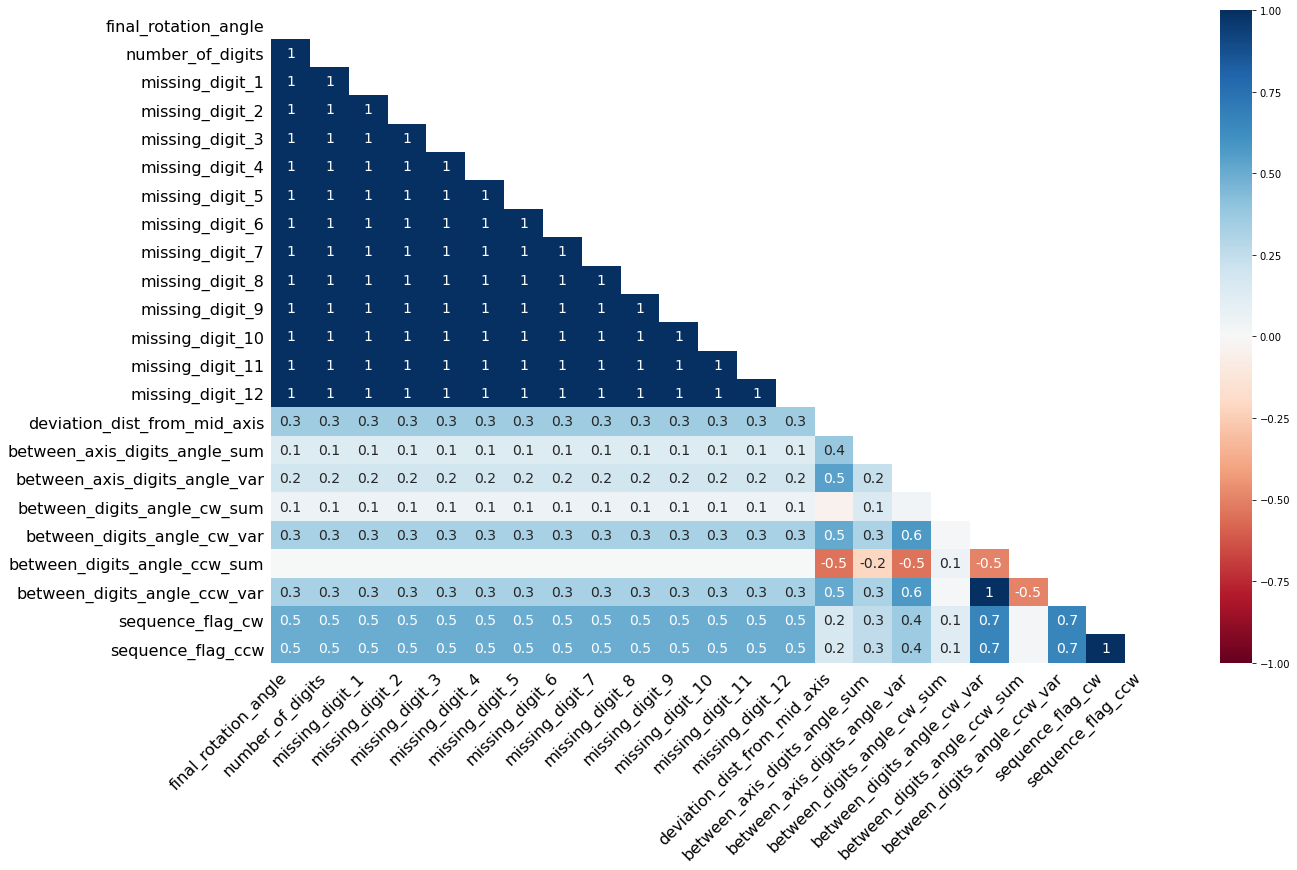

In [34]:
# in clock_features
missingno.heatmap(train_data[clock_features])

<AxesSubplot:>

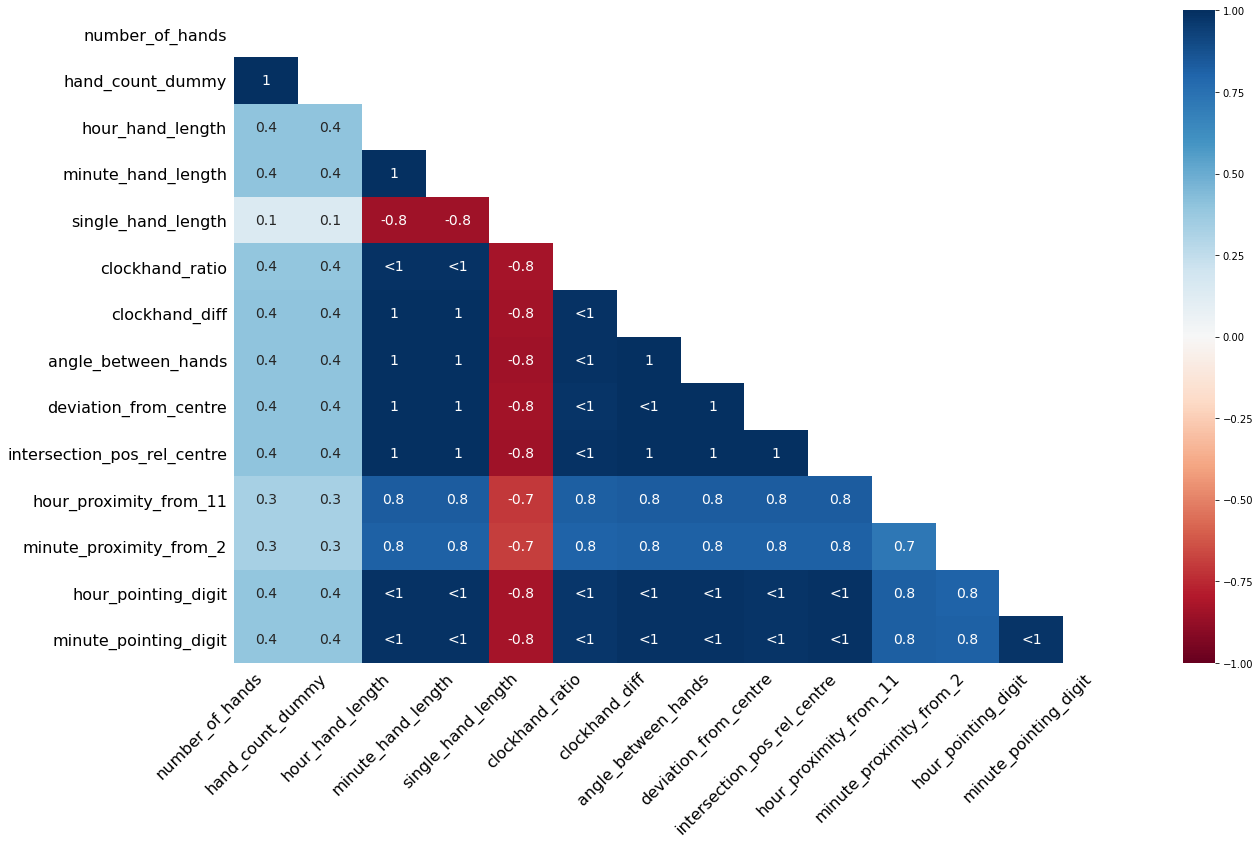

In [35]:
# in hand features
missingno.heatmap(train_data[hand_features])

<AxesSubplot:>

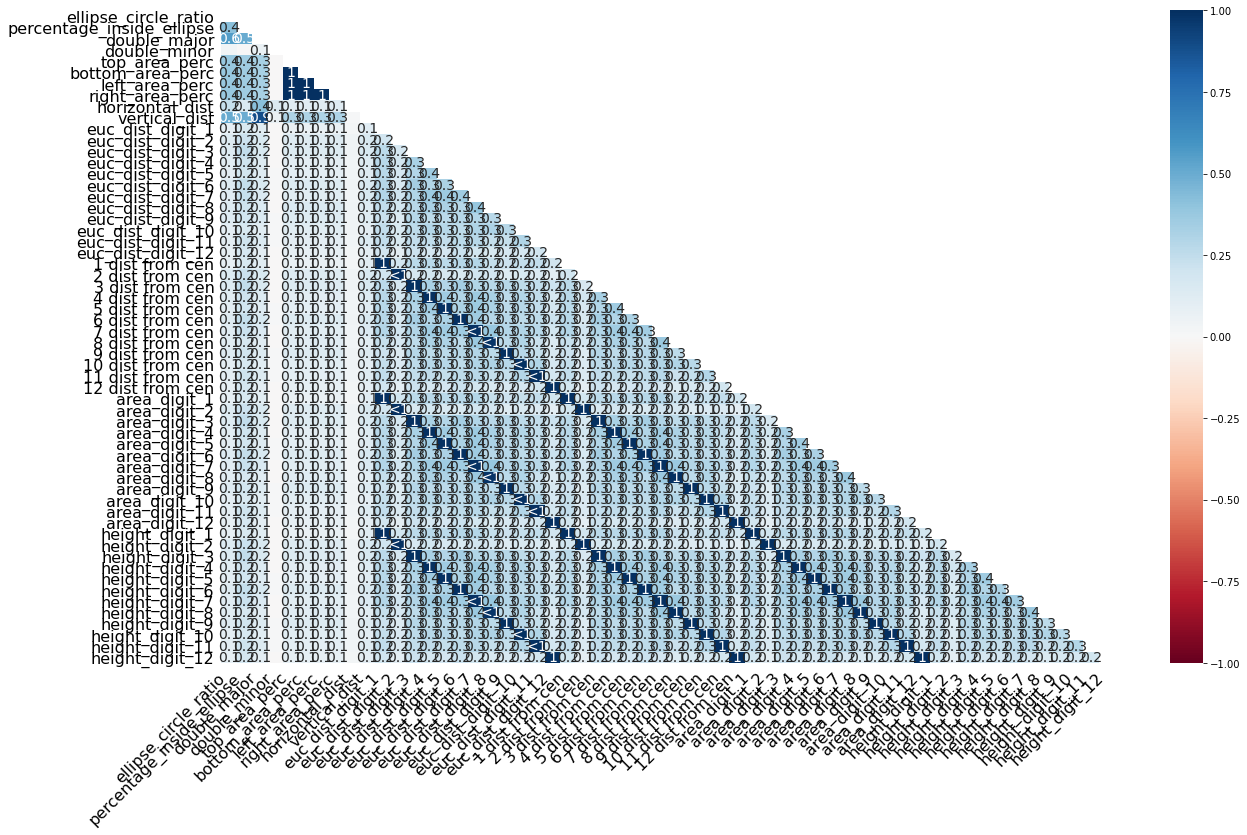

In [36]:
# circle features
missingno.heatmap(train_data[circle_features])

<AxesSubplot:>

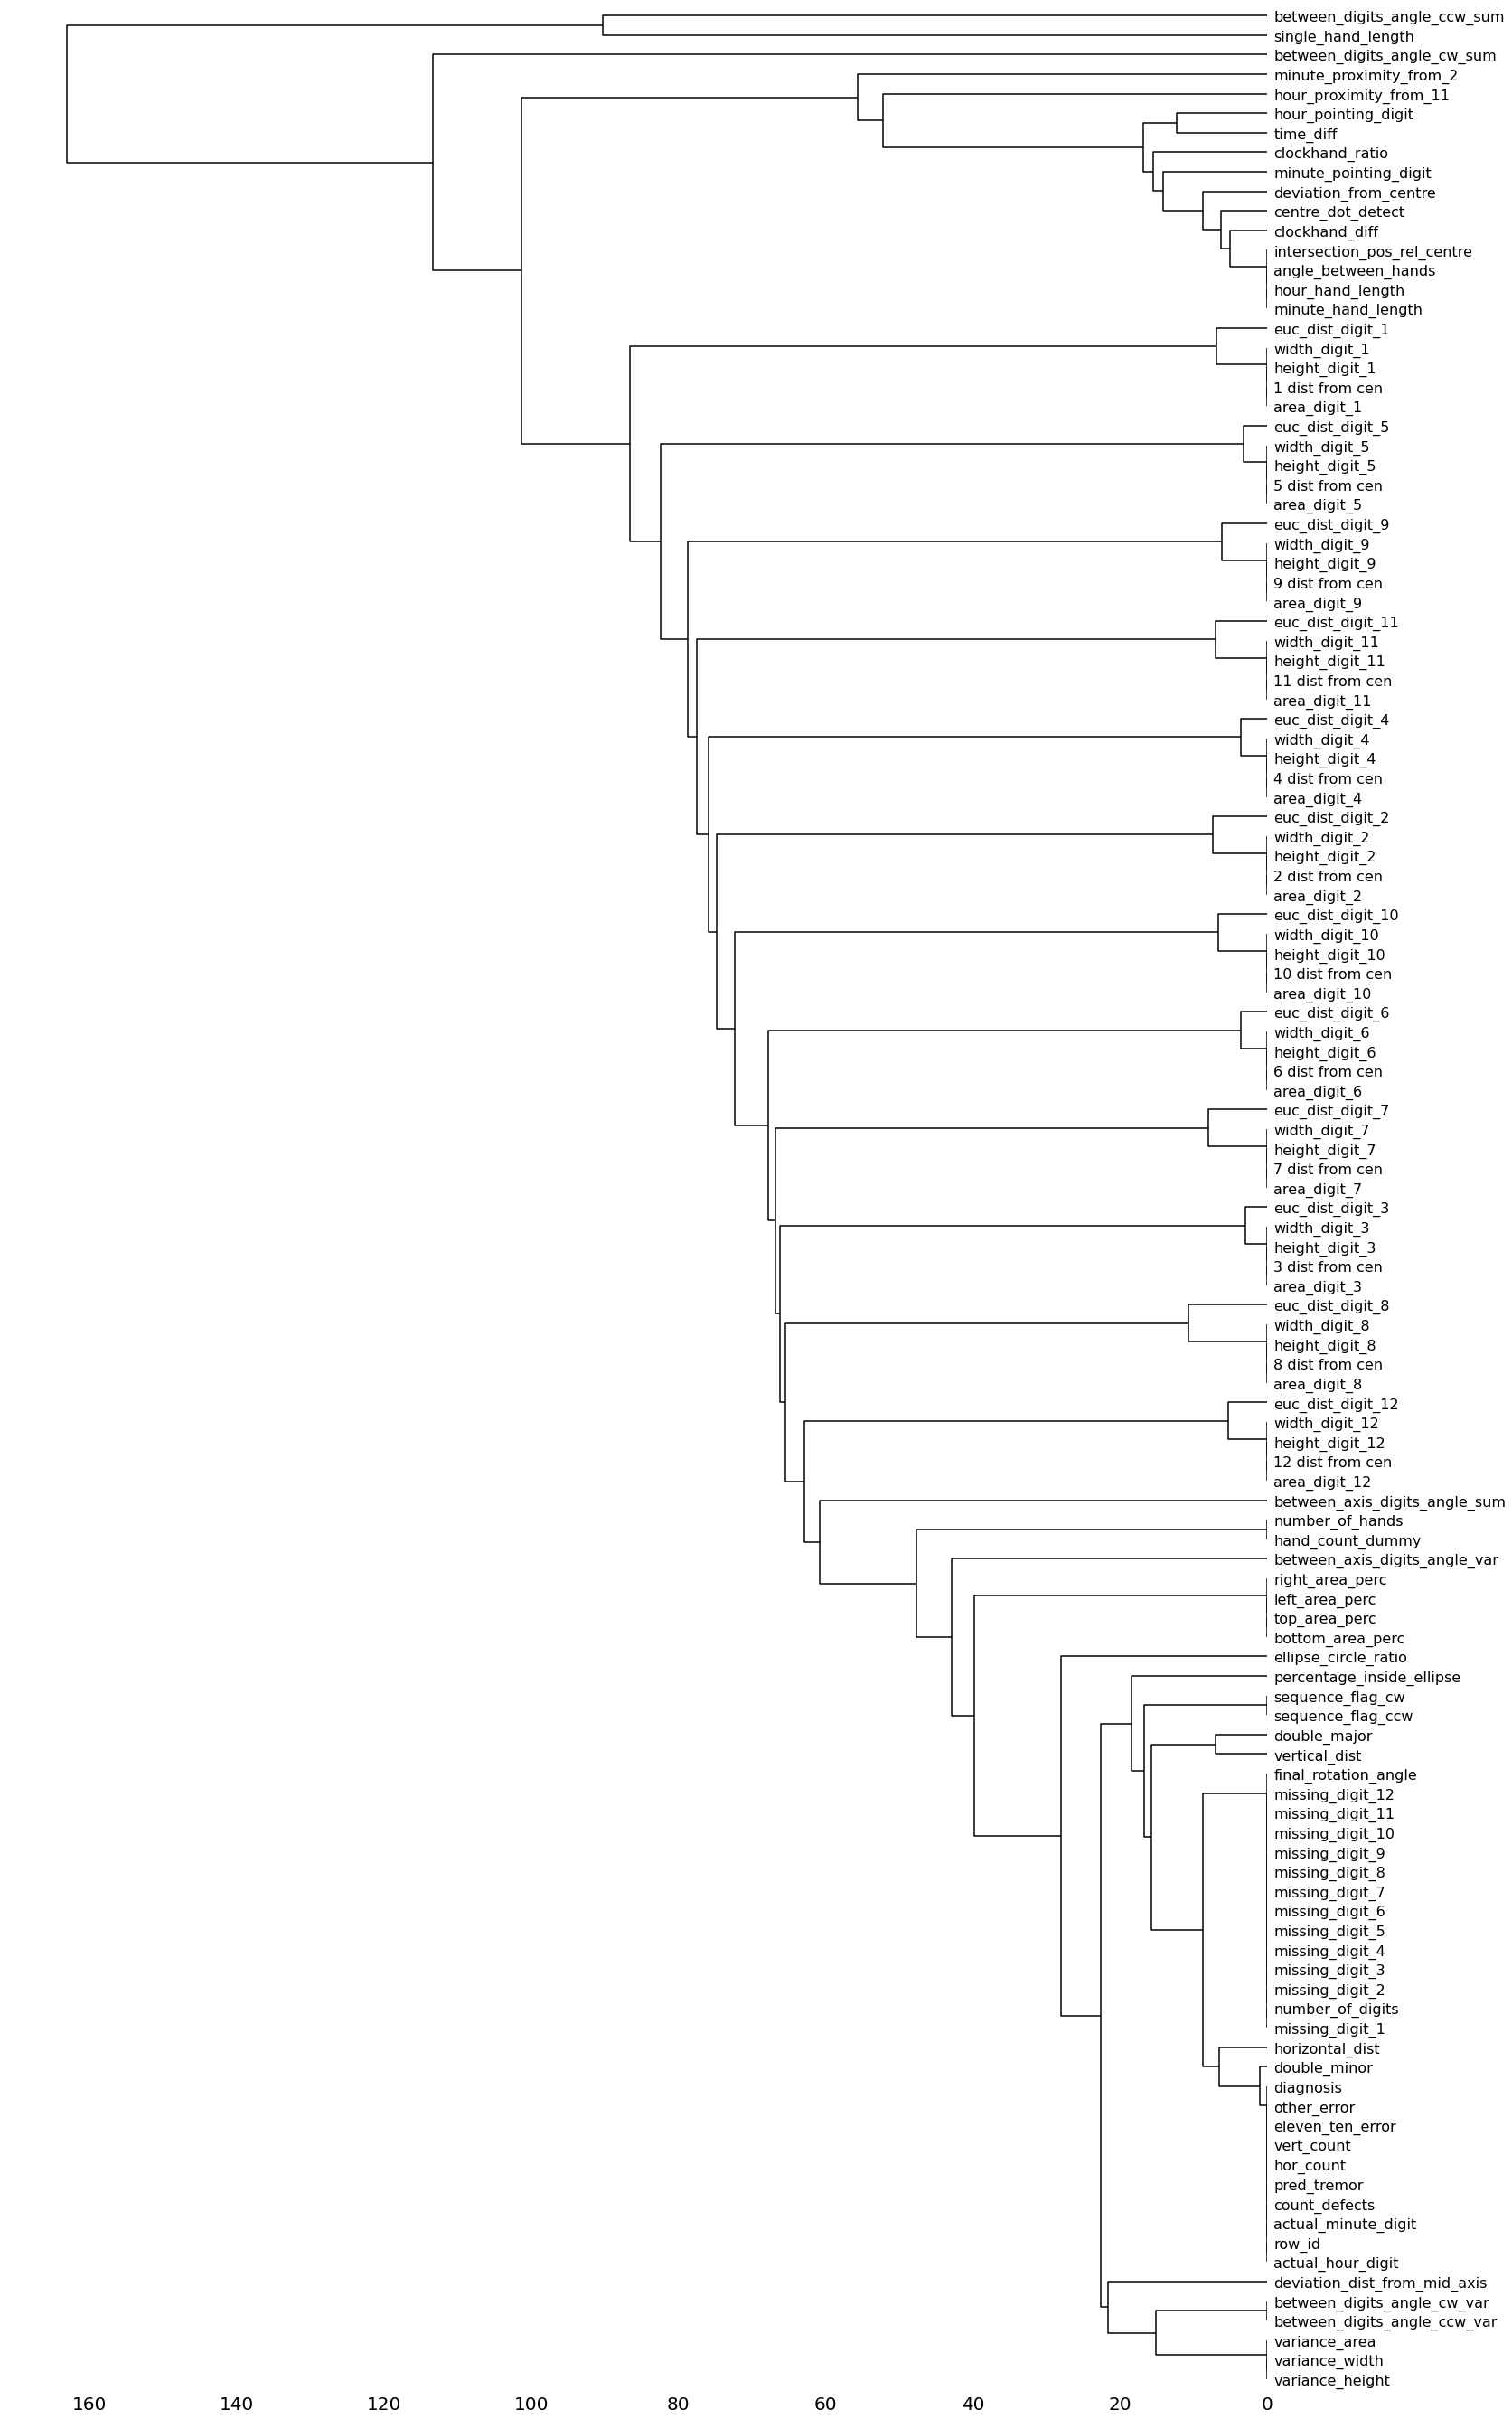

In [37]:
missingno.dendrogram(train_data)

##### Feat Engineering

In [38]:
# calling feat_engg on our data
feat_engg(df)

In [39]:
df.dtypes[df.dtypes==object]

row_id                         object
intersection_pos_rel_centre    object
dtype: object

In [40]:
# Count encoding
ce = CountEncoder(handle_missing='return_nan')
count_encoded = ce.fit_transform(df['intersection_pos_rel_centre'])

df = df.join(count_encoded.add_suffix("_count"))
df.drop('intersection_pos_rel_centre', axis=1, inplace=True)

In [41]:
# dropping columns with large number of  missing values
df.drop(discard_feat, axis=1, inplace=True)
df.head()

,row_id,number_of_digits,missing_digit_1,missing_digit_2,missing_digit_3,missing_digit_4,missing_digit_5,missing_digit_6,missing_digit_7,missing_digit_8,...,centre_dot_detect,deviation_dist_from_mid_axis_hor_count,deviation_dist_from_mid_axis_pred_tremor,number_of_digits_perc_inside,between_axis_digits_angle_var_perc_inside,double_minor_ellipse_circle_ratio,double_minor_count_defects,ellipse_circle_ratio_double_minor,ellipse_circle_ratio_count_defects,intersection_pos_rel_centre_count
0,S0CIXBKIUEOUBNURP,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,36.0,36.0,0.971732,0.692308,63.432966,94.0,82.428054,94.0,10362.0
1,IW1Z4Z3H720OPW8LL,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,12.0,12.0,0.971732,0.250000,42.043763,38.0,52.933264,38.0,NaN
2,PVUGU14JRSU44ZADT,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,18.0,18.0,0.971732,0.923077,77.635126,103.0,100.026343,103.0,5283.0
3,RW5UTGMB9H67LWJHX,7.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,...,NaN,2.0,2.0,0.873534,0.857143,67.623610,47.0,74.463887,47.0,NaN
4,W0IM2V6F6UP5LYS3E,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,52.0,52.0,0.971732,1.000000,90.858375,158.0,117.908961,158.0,4961.0


In [42]:
# standardizing df
scaler= StandardScaler()
df.iloc[:,1:] = scaler.fit_transform(df.iloc[:,1:])

In [44]:
df_train = df.iloc[:train_data.shape[0]]
df_train[TARGET_COL] = pd.factorize(train_data.loc[:,TARGET_COL], sort=True)[0]

<ipython-input-44-2c3d72337120>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train[TARGET_COL] = pd.factorize(train_data.loc[:,TARGET_COL], sort=True)[0]


In [45]:
df_train.diagnosis.value_counts()

0    31208
1     1149
2      420
Name: diagnosis, dtype: int64

In [46]:
train_cls_distribution = df_train.diagnosis.value_counts()/df_train.shape[0]
train_cls_distribution

0    0.952131
1    0.035055
2    0.012814
Name: diagnosis, dtype: float64

In [47]:
df_val = df.iloc[train_data.shape[0]:]
df_val[TARGET_COL] = pd.factorize(pd.read_csv(AICROWD_VAL_DATASET_PATH)['diagnosis'], sort=True)[0]

<ipython-input-47-7579bdbeb5c1>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_val[TARGET_COL] = pd.factorize(pd.read_csv(AICROWD_VAL_DATASET_PATH)['diagnosis'], sort=True)[0]


In [48]:
df_val.diagnosis.value_counts()

0    270
1     62
2     30
Name: diagnosis, dtype: int64

In [49]:
val_cls_distribution = df_val.diagnosis.value_counts()/df_val.shape[0]
val_cls_distribution

0    0.745856
1    0.171271
2    0.082873
Name: diagnosis, dtype: float64

In [50]:
df_train.diagnosis.values

array([0, 0, 0, ..., 0, 0, 0])

In [51]:
def apply_weight(x):
    if x == 0:
        return 0.10
    elif x == 1:
        return 1.0
    else:
        return 0.75

In [52]:
# train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(df_train.drop(['row_id', 'diagnosis'],  axis=1), df_train['diagnosis'],
                                                     test_size=0.15, stratify=df_train['diagnosis'], random_state=20210510)

# random oversampling   for creating  balanced dataset
# ros = RandomOverSampler(random_state=20210510)
# smote = SMOTE(random_state=27)
# X_resampled, y_resampled = ros.fit_resample(X_train, y_train)

## Train your model

In [53]:
import xgboost as xgb

In [54]:
w_train = np.apply_along_axis(apply_weight, 1, y_train.values.reshape(-1,1))
w_valid = np.apply_along_axis(apply_weight, 1, y_valid.values.reshape(-1,1))

In [57]:
dtrain = xgb.DMatrix(data=X_train, label=y_train,\
            weight=w_train)

In [58]:
dvalid = xgb.DMatrix(data=X_valid, label=y_valid,\
            weight=w_valid)

In [59]:
np.random.seed(20210510)

In [60]:
# setting parameters
# booster parameters
param = {'max_depth':6, 'eta':0.02, 'objective':'multi:softprob',
        'num_class':3, 'min_child_weight':5,
        'subsample':.95, 'colsample_bytree':.95, "tree_method":'hist',
        'booster':'gbtree'}
# param['nthred'] = 8
param['eval_metric'] = ['mlogloss']
evallist = [(dtrain, 'train'), (dvalid, 'eval')]

In [61]:
model_cv = xgb.cv(params=param, dtrain=dtrain,
                 num_boost_round=500, nfold=5, stratified=True,
                 verbose_eval=False, early_stopping_rounds=40)

In [62]:
best_iter = model_cv.shape[0]
best_iter

188

In [63]:
xgbc_model = xgb.train(params=param,
                       dtrain=dtrain,
                       num_boost_round=best_iter,
                       evals=evallist)

[0]	train-mlogloss:1.08276	eval-mlogloss:1.08366
[1]	train-mlogloss:1.06757	eval-mlogloss:1.06936
[2]	train-mlogloss:1.05264	eval-mlogloss:1.05544
[3]	train-mlogloss:1.03819	eval-mlogloss:1.04214
[4]	train-mlogloss:1.02420	eval-mlogloss:1.02918
[5]	train-mlogloss:1.01069	eval-mlogloss:1.01644
[6]	train-mlogloss:0.99758	eval-mlogloss:1.00417
[7]	train-mlogloss:0.98484	eval-mlogloss:0.99262
[8]	train-mlogloss:0.97246	eval-mlogloss:0.98127
[9]	train-mlogloss:0.96050	eval-mlogloss:0.97041
[10]	train-mlogloss:0.94875	eval-mlogloss:0.95980
[11]	train-mlogloss:0.93725	eval-mlogloss:0.94934
[12]	train-mlogloss:0.92621	eval-mlogloss:0.93928
[13]	train-mlogloss:0.91548	eval-mlogloss:0.92967
[14]	train-mlogloss:0.90497	eval-mlogloss:0.92031
[15]	train-mlogloss:0.89473	eval-mlogloss:0.91125
[16]	train-mlogloss:0.88482	eval-mlogloss:0.90229
[17]	train-mlogloss:0.87509	eval-mlogloss:0.89370
[18]	train-mlogloss:0.86572	eval-mlogloss:0.88534
[19]	train-mlogloss:0.85651	eval-mlogloss:0.87718
[20]	train

In [64]:
# computing log_loss on validation data
log_loss(df_val['diagnosis'], xgbc_model.predict(xgb.DMatrix(df_val.drop(['row_id', 'diagnosis'], axis=1))))

0.578105842596877

In [ ]:
# some custom code block

## Save your trained model

In [65]:
xgbc_model.save_model(AICROWD_ASSETS_DIR + '/model_001')
pickle.dump(scaler, open(AICROWD_ASSETS_DIR + '/scaler_001', "wb"))
pickle.dump(ce, open(AICROWD_ASSETS_DIR + '/ce_001', "wb"))
np.save(AICROWD_ASSETS_DIR + '/discard', discard_feat)
# np.save(AICROWD_ASSETS_DIR + '/reg', regr_features)
# np.save(AICROWD_ASSETS_DIR + '/cat', cat_features)

In [ ]:
# model.save()

# Prediction phase 🔎

Please make sure to save the weights from the training section in your assets directory and load them in this section

In [66]:
# model = load_model_from_assets_dir(AIcrowdConfig.ASSETS_DIR)
# from catboost import CatBoostClassifier
# from xgboost import XGBClassifier
import xgboost as xgb
# model = CatBoostClassifier()
model = xgb.Booster()
model.load_model(AICROWD_ASSETS_DIR + '/model_001')

## Load test data

In [67]:
scaler_test = pickle.load(open(AICROWD_ASSETS_DIR+'/scaler_001', 'rb'))
ce_test = pickle.load(open(AICROWD_ASSETS_DIR+'/ce_001', 'rb'))
discard_feat = np.load(AICROWD_ASSETS_DIR  +  '/discard.npy', allow_pickle=True)
# cat_features = np.load(AICROWD_ASSETS_DIR  +  '/cat.npy', allow_pickle=True)
# regr_features = np.load(AICROWD_ASSETS_DIR  +  '/reg.npy', allow_pickle=True)

In [68]:
test_data = pd.read_csv(AICROWD_DATASET_PATH)

feat_engg(test_data)
test_encoded = ce_test.transform(test_data['intersection_pos_rel_centre'])
test_data = test_data.join(test_encoded.add_suffix("_count"))
test_data.drop('intersection_pos_rel_centre', axis=1, inplace=True)
test_data.drop(discard_feat, axis=1, inplace=True)
test_data.iloc[:, 1:] = scaler_test.transform(test_data.iloc[:, 1:])
# test_data[cat_features] = test_data[cat_features].fillna(999)
# test_data[[feature for feature in cat_features if  feature != 'intersection_pos_rel_centre']] =\
# test_data[[feature for feature in cat_features if feature != 'intersection_pos_rel_centre']].astype(int)
test_data.head()

,row_id,number_of_digits,missing_digit_1,missing_digit_2,missing_digit_3,missing_digit_4,missing_digit_5,missing_digit_6,missing_digit_7,missing_digit_8,...,centre_dot_detect,deviation_dist_from_mid_axis_hor_count,deviation_dist_from_mid_axis_pred_tremor,number_of_digits_perc_inside,between_axis_digits_angle_var_perc_inside,double_minor_ellipse_circle_ratio,double_minor_count_defects,ellipse_circle_ratio_double_minor,ellipse_circle_ratio_count_defects,intersection_pos_rel_centre_count
0,LA9JQ1JZMJ9D2MBZV,0.300826,-0.535078,-0.417725,-0.379022,-0.448755,-0.504373,-0.390008,-0.382459,-0.371785,...,NaN,-1.201997,-1.201997,0.105724,0.344168,0.388949,0.317946,0.016699,0.287965,NaN
1,PSSRCWAPTAG72A1NT,-1.820558,1.868885,2.393922,-0.379022,2.228389,1.982662,-0.390008,-0.382459,-0.371785,...,NaN,-1.201997,-1.201997,-4.418724,0.344168,-0.396006,0.140482,-0.567042,0.105997,NaN
2,GCTODIZJB42VCBZRZ,0.300826,-0.535078,-0.417725,-0.379022,-0.448755,1.982662,-0.390008,-0.382459,-0.371785,...,-0.563882,-1.201997,-1.201997,0.105724,0.344168,0.498666,0.672873,1.157396,0.651900,-0.643905
3,7YMVQGV1CDB1WZFNE,-3.093388,1.868885,-0.417725,2.638369,-0.448755,1.982662,2.564048,2.614661,2.689725,...,NaN,-1.201997,-1.201997,-0.042220,NaN,-1.927166,-1.963732,-4.277458,-2.051621,NaN
4,PHEQC6DV3LTFJYIJU,-3.941941,1.868885,2.393922,2.638369,2.228389,1.982662,2.564048,2.614661,-0.371785,...,-0.563882,NaN,NaN,-6.290173,NaN,-1.721642,-1.913028,-1.511333,-1.999630,-0.752423


## Generate predictions

In [69]:
preds = model.predict(xgb.DMatrix(test_data.drop(['row_id'], axis=1)))

In [70]:
predictions = {
    "row_id": test_data["row_id"].values,
    "normal_diagnosis_probability": preds[:, 0],
    "post_alzheimer_diagnosis_probability": preds[:, 1],
    "pre_alzheimer_diagnosis_probability": preds[:, 2],
}

predictions_df = pd.DataFrame.from_dict(predictions)

In [71]:
pred_sum = predictions_df['normal_diagnosis_probability'] + predictions_df['post_alzheimer_diagnosis_probability'] + predictions_df['pre_alzheimer_diagnosis_probability']
predictions_df['normal_diagnosis_probability'] /= pred_sum 
predictions_df['post_alzheimer_diagnosis_probability'] /= pred_sum 
predictions_df['pre_alzheimer_diagnosis_probability'] /= pred_sum
predictions_df['normal_diagnosis_probability'] + predictions_df['post_alzheimer_diagnosis_probability'] + predictions_df['pre_alzheimer_diagnosis_probability']

0      1.0
1      1.0
2      1.0
3      1.0
4      1.0
      ... 
357    1.0
358    1.0
359    1.0
360    1.0
361    1.0
Length: 362, dtype: float32

In [72]:
# to verify all sum to 362
(predictions_df['normal_diagnosis_probability'] + predictions_df['post_alzheimer_diagnosis_probability'] + predictions_df['pre_alzheimer_diagnosis_probability']).sum()

362.0

In [ ]:
# predictions = {
#     "row_id": test_data["row_id"].values,
#     "normal_diagnosis_probability": np.random.rand(len(test_data["row_id"].values))*0.1,
#     "post_alzheimer_diagnosis_probability": np.random.rand(len(test_data["row_id"].values))*0.1,
#     "pre_alzheimer_diagnosis_probability": np.random.rand(len(test_data["row_id"].values))*0.1,
# }

# predictions_df = pd.DataFrame.from_dict(predictions)

## Save predictions 📨

In [73]:
predictions_df.to_csv(AICROWD_PREDICTIONS_PATH, index=False)

# Submit to AIcrowd 🚀

**NOTE: PLEASE SAVE THE NOTEBOOK BEFORE SUBMITTING IT (Ctrl + S)**

In [ ]:
!DATASET_PATH=$AICROWD_DATASET_PATH \
aicrowd notebook submit \
    --assets-dir $AICROWD_ASSETS_DIR \
    --challenge addi-alzheimers-detection-challenge